<a href="https://colab.research.google.com/github/simon-mellergaard/datasimon/blob/main/Kaggle%20competitions/Predicting-beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting beats per minutes in songs

link to competition: https://www.kaggle.com/competitions/playground-series-s5e9

In [8]:
# SETUP CODE
import sys
import os
import warnings

warnings.filterwarnings("ignore")

IN_COLAB = 'google.colab' in sys.modules
competition = 'playground-series-s5e9'

if IN_COLAB:
    import kagglehub
    from google.colab import userdata
    !mkdir ~/.kaggle
    !echo -n '{"username":"simonmellergaard","key":"' > ~/.kaggle/kaggle.json
    !echo -n {userdata.get('Kaggle')} >> ~/.kaggle/kaggle.json
    !echo -n '"}' >> ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    comp_path = kagglehub.competition_download(competition)
    print('Data source import complete and located at: ' + comp_path)
    INPUT_PATH = '/root/.cache/kagglehub/competitions/' + competition
else:
    INPUT_PATH = f'/kaggle/input/{competition}'
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
CURRENT_DIR = os.getcwd()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Data source import complete and located at: /root/.cache/kagglehub/competitions/playground-series-s5e9


In [17]:
import pandas as pd
data_raw = pd.read_csv(f'{INPUT_PATH}/train.csv', index_col='id')
data_test = pd.read_csv(f'{INPUT_PATH}/test.csv', index_col='id')
data_raw.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [10]:
data_raw.shape

(524164, 10)

500.000 records, 10 features.

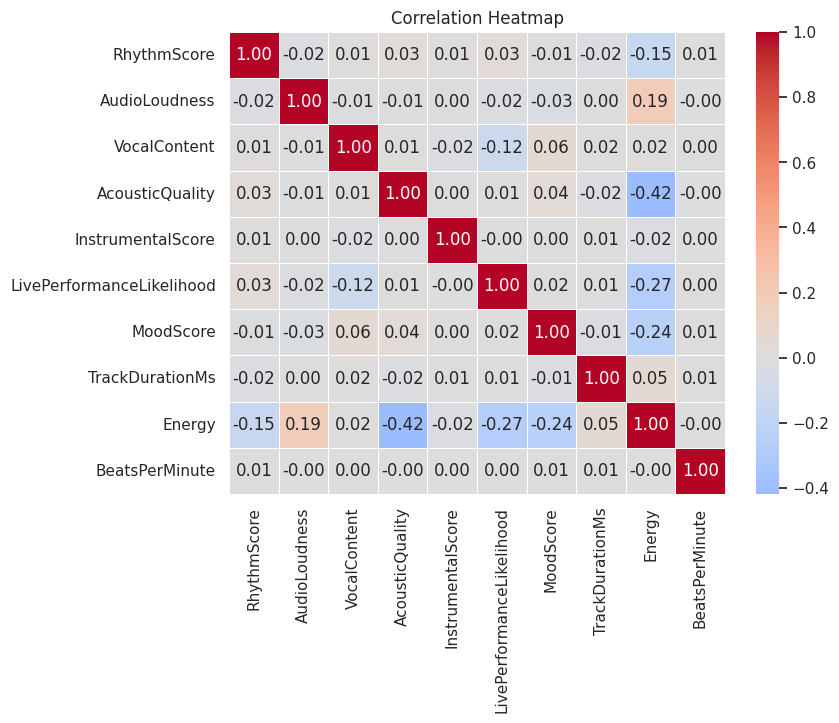

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = data_raw.corr()

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, center=0)
plt.title("Correlation Heatmap")
plt.show()

The data looks interesting

In [12]:
data_raw.isna().sum()

,0
RhythmScore,0
AudioLoudness,0
VocalContent,0
AcousticQuality,0
InstrumentalScore,0
LivePerformanceLikelihood,0
MoodScore,0
TrackDurationMs,0
Energy,0
BeatsPerMinute,0


In [13]:
data_raw.describe()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


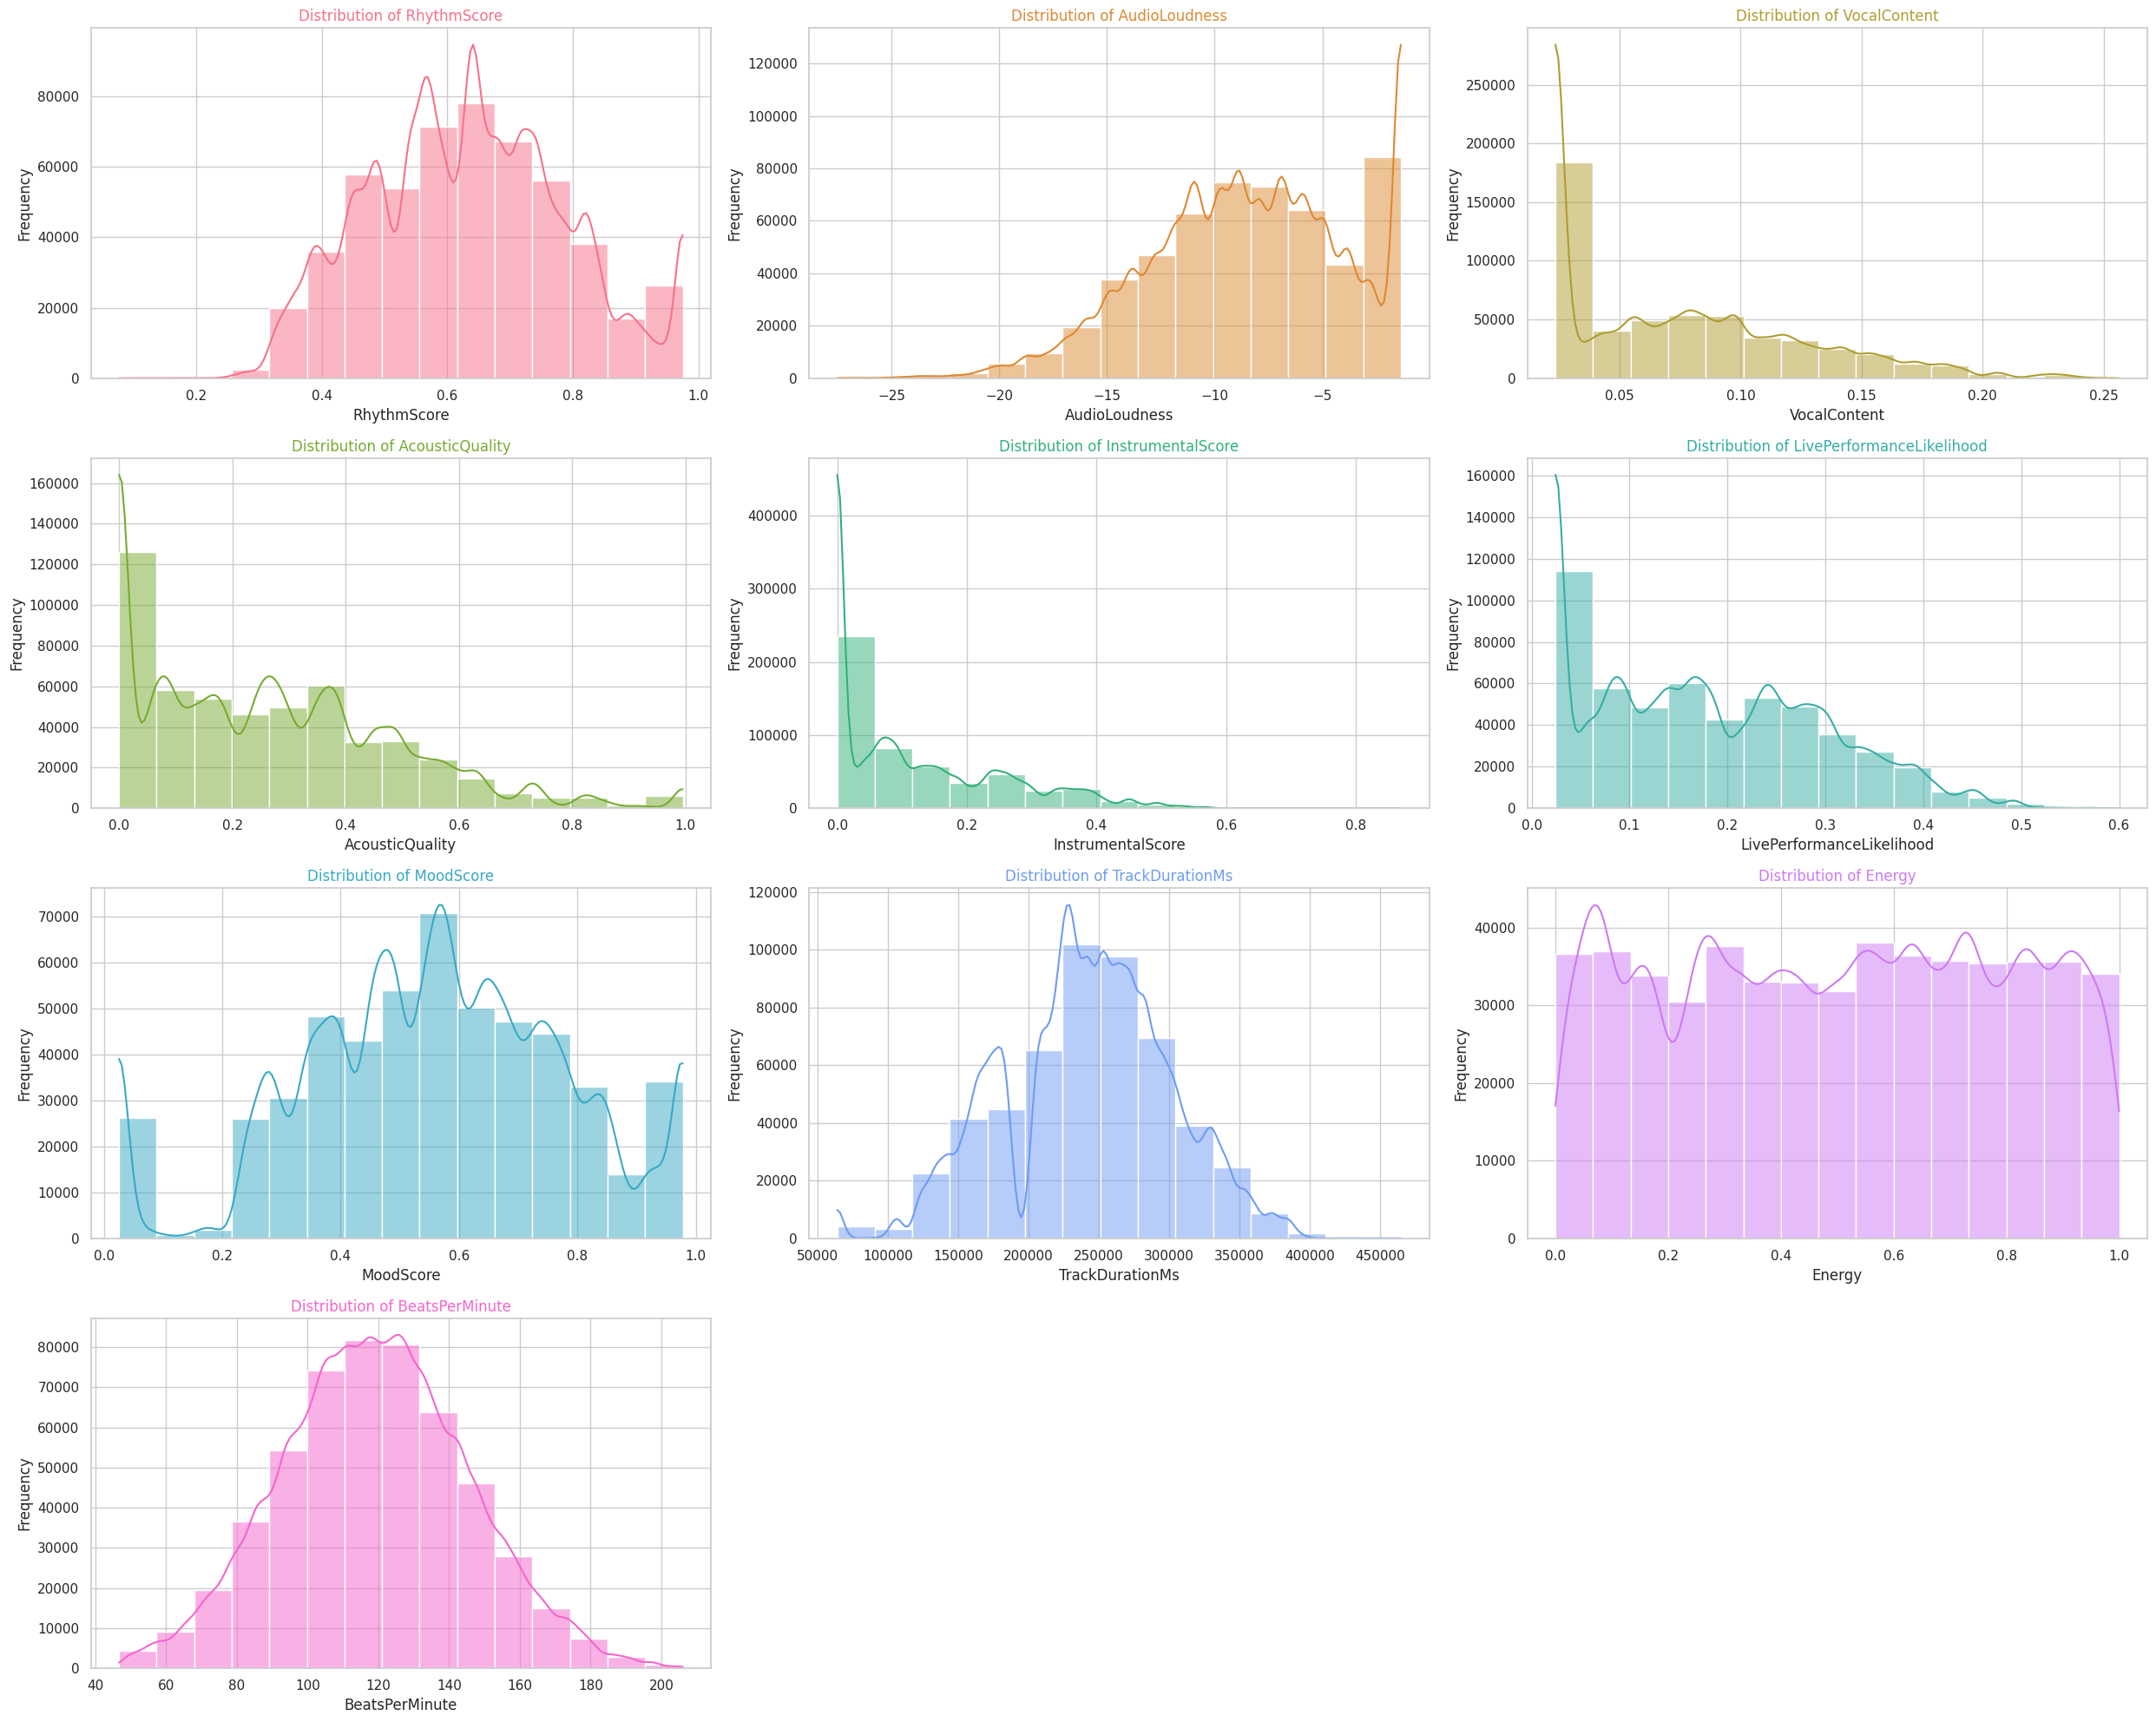

In [7]:
# Source: https://www.kaggle.com/code/pacificrm/playing-with-beats-detailed-eda-feature-eng
sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(data_raw.columns))

plt.figure(figsize=(25, 20))
for i, (col, color) in enumerate(zip(data_raw.columns, colors), 1):
    plt.subplot(len(data_raw.columns) // 3 + 1, 3, i)
    sns.histplot(data_raw[col], bins=15, kde=True, color=color)
    plt.title(f'Distribution of {col}', color=color)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The data looks very good. Let's make models.

In [22]:
from sklearn.model_selection import train_test_split

X = data_raw.drop('BeatsPerMinute', axis=1)
y = data_raw['BeatsPerMinute']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)
preds = model.predict(X_test)
root_mean_squared_error(preds, y_test)

26.531959581907184

In [29]:
# Make a grid search for the xgboost

from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(eval_metric='rmse')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
help(rmse
)